In [22]:
#%% (1) 0.0 load modules and packages
import os
import re
import pandas as pd
import numpy as np

from IPython.display import display
from scipy.stats import fisher_exact
from statsmodels.stats.proportion import proportions_ztest
from pathlib import Path
import hashlib
from collections import defaultdict
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype

# sklearn bits
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer


from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr

In [23]:
#%% (2) 0.1 path
csv_path = Path("C:/Users/USER/OneDrive/Documents/Olga Documents/Mccb/ds_assignment_data/ds_assignment_data.csv") 

In [24]:
#%% (3) 0.2 load 
df = pd.read_csv(csv_path)
print('CSV loaded:', csv_path)
print('Rows:', len(df), 'Columns:', len(df.columns))

Data_HC= df.copy() # saved unchanged copy
df_data = df.copy() # working copy

CSV loaded: C:\Users\USER\OneDrive\Documents\Olga Documents\Mccb\ds_assignment_data\ds_assignment_data.csv
Rows: 10000 Columns: 157


In [25]:
#%% (4) 1: Data rearrangment

# SECTION 1.1: Flags 

# Some datasets use 'match_diag_141' instead of 'match_diag_after'.
if 'match_diag_after' not in df_data.columns:
    if 'match_diag_141' in df_data.columns:
        df_data['match_diag_after'] = df_data['match_diag_141']
    else:
        df_data['match_diag_after'] = 0 

for c in ['match_measure_after','match_rasham_after','match_aspirin_after','match_pdf_after']:
    if c not in df_data.columns:
        df_data[c] = 0
        
# SECTION 1.3: Clinical text 

#  clinical notes in 'clinical_sheet', map into 'clinical_text'.
if 'clinical_text' not in df_data.columns:
    if 'clinical_sheet' in df_data.columns:
        df_data['clinical_text'] = df_data['clinical_sheet']
    else:
        df_data['clinical_text'] = pd.NA
        

# Features by Group function

def _map_if_exists(short_name, long_name):
    if long_name in df_data.columns:
        df_data[short_name] = df_data[long_name]
    elif short_name not in df_data.columns:
        df_data[short_name] = pd.NA

# SECTION 1.3: Labs (CBC)    
cbc_map = {
    'WBC': 'lab_White Blood Cells (WBC)_last_value',
    'RBC': 'lab_Red Blood Cells (RBC)_last_value',
    'MPV': 'lab_Mean Platelet Volume (MPV)_last_value',
    'HGB': 'lab_Hemoglobin (HGB)_last_value',
    'HCT': 'lab_Hematocrit (HCT)_last_value',
    'RCC': 'lab_Red Cell Count (RCC)_last_value',
    'MCH': 'lab_Mean Corpuscular Hemoglobin (MCH)_last_value',
    'MCHC': 'lab_Mean Corpuscular Hemoglobin Concentration (MCHC)_last_value',
    'RDW': 'lab_Red Cell Distribution Width (RDW)_last_value',
    'PLT': 'lab_Platelets (PLT)_last_value',
    'Neutrophils_1': 'lab_Neutrophils_1_last_value',
    'Neutrophils_2': 'lab_Neutrophils_2_last_value',
    'Lymphocytes_1': 'lab_Lymphocytes_1_last_value',
    'Lymphocytes_2': 'lab_Lymphocytes_2_last_value',
    'Monocytes_1': 'lab_Monocytes_1_last_value',
    'Monocytes_2': 'lab_Monocytes_2_last_value',
    'Eosinophils_1': 'lab_Eosinophils_1_last_value',
    'Eosinophils_2': 'lab_Eosinophils_2_last_value',
    'Basophils_1': 'lab_Basophils_1_last_value',
    'Basophils_2': 'lab_Basophils_2_last_value',
}
for short, longcol in cbc_map.items():
    _map_if_exists(short, longcol)     
    

# SECTION 1.3: Biochemical labs 
biochem_map = {
    'papp_a_MoM': 'lab_papp_a_MoM_last_value',
    'papp_a_abs': 'lab_papp_a_abs_last_value',
    'b_hcg_MoM': 'lab_b_hcg_MoM_last_value',
    'b_hcg_abs': 'lab_b_hcg_abs_last_value',
    'NT_MoM': 'lab_NT_MoM_last_value',
    'NT_abs': 'lab_NT_abs_last_value',
    'weight_at_lab_time': 'lab_weight_at_lab_time_last_value',
}

for short, longcol in biochem_map.items():
    _map_if_exists(short, longcol)      
    
# SECTION 1.3: Urine labs 
_map_if_exists('Protein-U', 'lab_Protein-U_last_value')
_map_if_exists('pH-U', 'lab_pH-U_last_value')

# SECTION 0.8: Blood pressure summary + simple trends
_map_if_exists('systolic_mean',  'measure_blood_pressure_sys_mean_val')
_map_if_exists('systolic_max',   'measure_blood_pressure_sys_max_val')
_map_if_exists('diastolic_mean', 'measure_blood_pressure_dias_mean_val')
_map_if_exists('diastolic_max',  'measure_blood_pressure_dias_max_val')

if {'measure_blood_pressure_sys_first_val','measure_blood_pressure_sys_last_val'} <= set(df_data.columns):
    df_data['systolic_trend'] = df_data['measure_blood_pressure_sys_last_val'] - df_data['measure_blood_pressure_sys_first_val']
else:
    if 'systolic_trend' not in df_data.columns:
        df_data['systolic_trend'] = pd.NA

if {'measure_blood_pressure_dias_first_val','measure_blood_pressure_dias_last_val'} <= set(df_data.columns):
    df_data['diastolic_trend'] = df_data['measure_blood_pressure_dias_last_val'] - df_data['measure_blood_pressure_dias_first_val']
else:
    if 'diastolic_trend' not in df_data.columns:
        df_data['diastolic_trend'] = pd.NA
        

# SECTION 1.2: Diagnostic subtype counts

# Keep existing values; if a column is missing, create it with 0.
subtype_cols = [
    'secondary_hypertension_sum','essential_hypertension_sum','hypertensive_heart_disease_sum',
    'hypertensive_chronic_kidney_disease_sum','hypertensive_heart_and_chronic_kidney_disease_sum',
    'pregnancy_hypertension_sum','preeclampsia_sum','eclampsia_sum','labs_sum']

for c in subtype_cols:
    if c not in df_data.columns:
        df_data[c] = 0
        
# Demographics (use structured fields only) 
if 'Age' not in df_data.columns:
    if 'demog_customer_age' in df_data.columns:
        df_data['Age'] = df_data['demog_customer_age']
    else:
        df_data['Age'] = pd.NA

if 'SES' not in df_data.columns:
    if 'demog_capitationcoefficient' in df_data.columns:
        df_data['SES'] = df_data['demog_capitationcoefficient']
    else:
        df_data['SES'] = pd.NA

# Final order: SPEC first, then everything else 

spec_first = [
    'Y','Source breakdown',
    'match_diag_after','match_measure_after','match_rasham_after','match_aspirin_after','match_pdf_after',
    'secondary_hypertension_sum','essential_hypertension_sum','hypertensive_heart_disease_sum',
    'hypertensive_chronic_kidney_disease_sum','hypertensive_heart_and_chronic_kidney_disease_sum',
    'pregnancy_hypertension_sum','preeclampsia_sum','eclampsia_sum','labs_sum',
    'clinical_text',
    'WBC','RBC','MPV','HGB','HCT','RCC','MCH','MCHC','RDW','PLT',
    'Neutrophils_1','Neutrophils_2','Lymphocytes_1','Lymphocytes_2',
    'Monocytes_1','Monocytes_2','Eosinophils_1','Eosinophils_2','Basophils_1','Basophils_2',
    'papp_a_MoM','papp_a_abs','b_hcg_MoM','b_hcg_abs','NT_MoM','NT_abs','weight_at_lab_time',
    'Protein-U','pH-U',
    'systolic_mean','systolic_max','diastolic_mean','diastolic_max','systolic_trend','diastolic_trend',
    'Age','SES',
]
keep = [c for c in spec_first if c in df_data.columns]
rest = [c for c in df_data.columns if c not in keep]
df_data = df_data[keep + rest]


# Show a preview 
print('\nFirst 5 rows (spec-aligned):\n', df_data.head())


First 5 rows (spec-aligned):
    Y  match_diag_after  match_measure_after  match_rasham_after  \
0  0                 0                    0                   0   
1  0                 0                    0                   0   
2  0                 0                    0                   0   
3  0                 0                    0                   0   
4  0                 0                    0                   0   

   match_aspirin_after  match_pdf_after  secondary_hypertension_sum  \
0                    0                0                           0   
1                    0                0                           0   
2                    0                0                           0   
3                    0                0                           0   
4                    0                0                           0   

   essential_hypertension_sum  hypertensive_heart_disease_sum  \
0                           0                               0   
1        

In [26]:
#%% (5) Create the working dataset 

doc_spec_order = [
    "Y",
    "match_diag_after","match_measure_after","match_rasham_after","match_aspirin_after","match_pdf_after",
    "secondary_hypertension_sum","essential_hypertension_sum","hypertensive_heart_disease_sum",
    "hypertensive_chronic_kidney_disease_sum","hypertensive_heart_and_chronic_kidney_disease_sum",
    "pregnancy_hypertension_sum","preeclampsia_sum","eclampsia_sum","labs_sum",
    "clinical_text",
    "WBC","RBC","MPV","HGB","HCT","RCC","MCH","MCHC","RDW","PLT",
    "Neutrophils_1","Neutrophils_2","Lymphocytes_1","Lymphocytes_2",
    "Monocytes_1","Monocytes_2","Eosinophils_1","Eosinophils_2","Basophils_1","Basophils_2",
    "papp_a_MoM","papp_a_abs","b_hcg_MoM","b_hcg_abs","NT_MoM","NT_abs","weight_at_lab_time",
    "Protein-U","pH-U",
    "systolic_mean","systolic_max","diastolic_mean","diastolic_max","systolic_trend","diastolic_trend",
    "Age","SES",
]
doc_rank = {name:i for i,name in enumerate(doc_spec_order)}

def sig(s: pd.Series) -> str:
    h = pd.util.hash_pandas_object(s, index=False)
    return hashlib.sha1(h.to_numpy(dtype="uint64", na_value=0).tobytes()).hexdigest()

sig2cols = defaultdict(list)
for c in df_data.columns:
    sig2cols[sig(df_data[c])].append(c)

to_drop = []
for cols in sig2cols.values():
    if len(cols) <= 1:
        continue
    # prefer a docx name if present; otherwise keep the first as-is
    spec = [c for c in cols if c in doc_rank]
    if spec:
        keep = sorted(spec, key=lambda x: doc_rank[x])[0]
    else:
        keep = cols[0]
    to_drop.extend([c for c in cols if c != keep])

df_data_dedup = df_data.drop(columns=to_drop, errors="ignore")
print("Dropped:", len(to_drop))
print("New shape:", df_data_dedup.shape)

df_data_dedup_path = Path('C:/Users/USER/OneDrive/Documents/Olga Documents/Mccb/ds_assignment_data/df_data_dedup.csv')
df_data_dedup.to_csv(df_data_dedup_path, index=False) 

Dropped: 41
New shape: (10000, 155)


Rows: 10000
Columns: 155
Approx. memory (MB): 61.11

Missingness (top 20):
                                 missing_count  missing_pct
Basophils_2                              10000       100.00
4_diag_88_days_since_last_diag           10000       100.00
4_diag_90_days_since_last_diag            9999        99.99
4_diag_106_days_since_last_diag           9999        99.99
4_diag_136_days_since_last_diag           9999        99.99
4_diag_126_days_since_last_diag           9999        99.99
24_diag_73_days_since_last_diag           9998        99.98
4_diag_120_days_since_last_diag           9997        99.97
4_diag_98_days_since_last_diag            9990        99.90
4_diag_102_days_since_last_diag           9989        99.89
4_diag_114_days_since_last_diag           9989        99.89
24_diag_53_days_since_last_diag           9988        99.88
4_diag_108_days_since_last_diag           9987        99.87
24_diag_77_days_since_last_diag           9987        99.87
24_diag_75_days_since_las

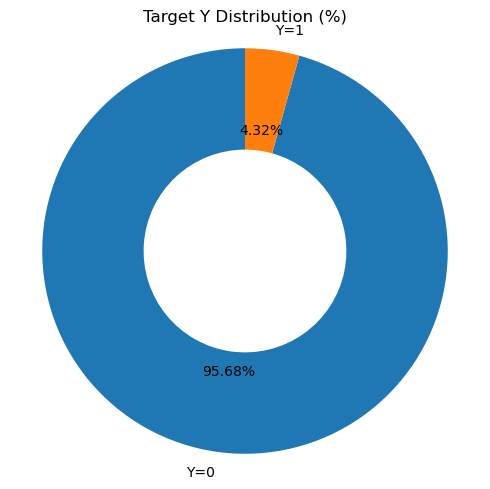

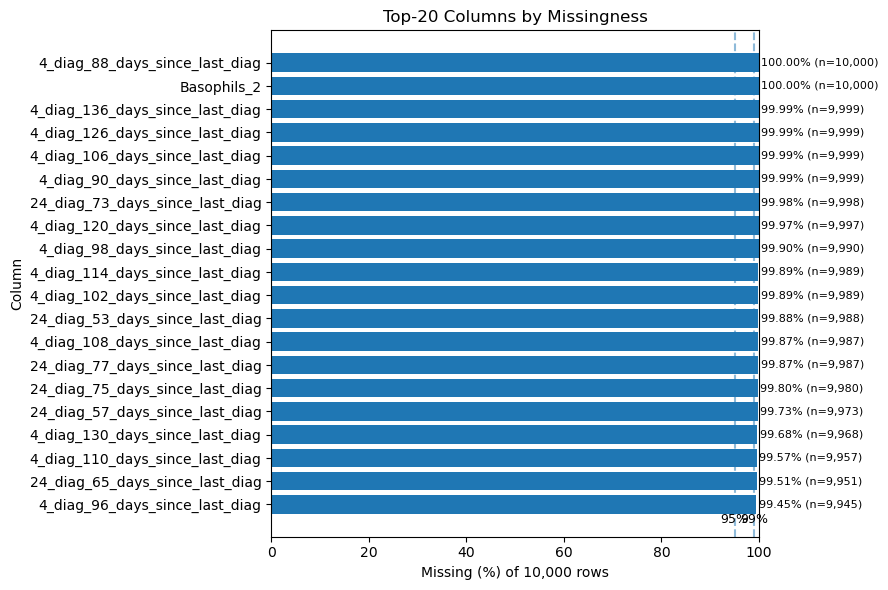

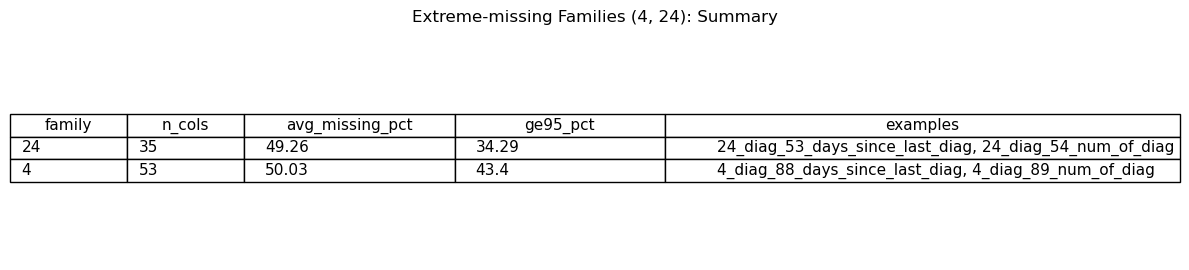

  Group  n_cols  median_nonnull_%  min_%  max_%
0  Labs      63              3.41   0.00  100.0
1    BP       8            100.00  49.89  100.0


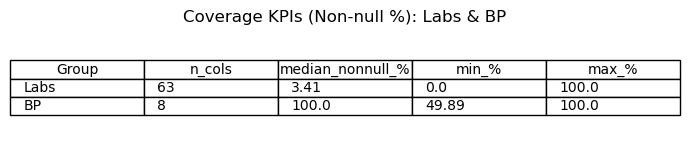

In [27]:
#%% (6) Question Task 1: 1.	Data Exploration
# Get to know the dataset—its size, distributions, missingness, and the relationships between key variables.

# 1.1.1 
# Size and memory 
rows, cols = df_data_dedup.shape
memory_mb = df_data_dedup.memory_usage(deep=True).sum() / (1024**2)
print("Rows:", rows)
print("Columns:", cols)
print("Approx. memory (MB):", round(memory_mb, 2))

# Missingness 
missing_count = df_data_dedup.isna().sum().sort_values(ascending=False)
missing_pct = (missing_count / len(df_data_dedup) * 100).round(2)
missing_table = pd.DataFrame({"missing_count": missing_count, "missing_pct": missing_pct})
print("\nMissingness (top 20):")
print(missing_table.head(20))

# Target distribution (if Y exists) 
if "Y" in df_data_dedup.columns:
    y_counts = df_data_dedup["Y"].value_counts(dropna=False)
    y_pct = (y_counts / len(df_data_dedup) * 100).round(2)
    print("\nTarget Y distribution:")
    print(pd.DataFrame({"count": y_counts, "pct": y_pct}))


# Numeric summary 
numeric_cols = df_data_dedup.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) > 0:
    print("\nNumeric summary (describe):")
    print(df_data_dedup[numeric_cols].describe())


## VISUALIZATION##

#% Y=1 Dounat Chart
fig2, ax2 = plt.subplots(figsize=(5, 5))
ax2.pie(y_counts,
        labels= ['Y=0','Y=1'],
        autopct="%1.2f%%",
        startangle=90,
        wedgeprops={"width": 0.5})  # width<1 makes it a donut
ax2.set_title("Target Y Distribution (%)")
ax2.axis("equal")
fig2.tight_layout()


#Top-20 Missingness horizontal bar + faint guides at 95% and 99%

df = df_data_dedup.copy()

# Build the top-20 table
missing_count = df.isna().sum().sort_values(ascending=False)
missing_pct   = (missing_count / len(df) * 100)
top20 = pd.DataFrame({"missing_count": missing_count, "missing_pct": missing_pct}).head(20)

# Sort so the bars read bottom→top nicely
top20 = top20.sort_values("missing_pct")

# Plot
plt.figure(figsize=(9, 6))
plt.barh(top20.index, top20["missing_pct"])
plt.xlim(0, 100)
plt.xlabel(f"Missing (%) of {len(df):,} rows")
plt.ylabel("Column")
plt.title("Top-20 Columns by Missingness")

# Light vertical guides at 95% and 99%
plt.axvline(95, linestyle="--", alpha=0.5)
plt.axvline(99, linestyle="--", alpha=0.5)
plt.text(95, -0.8, "95%", ha="center", fontsize=9)
plt.text(99, -0.8, "99%", ha="center", fontsize=9)

# Optional labels at the bar ends
for y, (pct, cnt) in enumerate(zip(top20["missing_pct"], top20["missing_count"])):
    plt.text(pct + 0.5, y, f"{pct:.2f}% (n={int(cnt):,})", va="center", fontsize=8)

plt.tight_layout()
plt.show()


## Extreme-missing families mini-table (families 4 and 24)

# Per-column missing % and family name (first token before "_")
miss_pct = df.isna().mean() * 100
families = pd.Index(df.columns).str.split("_").str[0].astype(str)

tmp = pd.DataFrame({"family": families, "col": df.columns, "miss_pct": miss_pct.values})

# Summary by family
summary = (tmp.groupby("family")
             .agg(n_cols=("col", "size"),
                  avg_missing_pct=("miss_pct", "mean"),
                  ge95_pct=("miss_pct", lambda s: (s >= 95).mean() * 100),
                  examples=("col", lambda s: ", ".join(s.head(2))))
             .reset_index()
             .round(2))

# Keep only families "4" and "24"
mini = summary[summary["family"].isin(["4", "24"])]

# Show as a small on-slide table
fig, ax = plt.subplots(figsize=(12, 2.8))
ax.axis("off")
tbl = ax.table(cellText=mini.values.tolist(),
               colLabels=mini.columns.tolist(),
               colWidths=[0.10, 0.10, 0.18, 0.18, 0.44],
               loc="center", cellLoc="left")
tbl.auto_set_font_size(False)
tbl.set_fontsize(11)
tbl.scale(1, 1.3)
ax.set_title("Extreme-missing Families (4, 24): Summary", pad=10)
plt.tight_layout()
plt.show()

## Coverage KPIs — Labs and BP median/min/max non-null %

# Pick columns by simple keywords (case-insensitive)
lab_keywords = ["WBC","RBC","HGB","HCT","RDW","MPV","PLT","Protein-U","CREAT","CREA","UREA","ALT","AST","CRP"]
bp_keywords  = ["systolic", "diastolic", "SBP", "DBP", "MAP", "trend", "mean", "max"]

labs_cols = [c for c in df.columns if any(k.lower() in c.lower() for k in lab_keywords)]
bp_cols   = [c for c in df.columns if any(k.lower() in c.lower() for k in bp_keywords)]

def cov_row(cols, name):
    if len(cols) == 0:
        return [name, 0, np.nan, np.nan, np.nan]
    cov = df[cols].notna().mean() * 100  # non-null %
    return [name, len(cols), round(float(cov.median()),2),
            round(float(cov.min()),2), round(float(cov.max()),2)]

kpi = pd.DataFrame([cov_row(labs_cols, "Labs"), cov_row(bp_cols, "BP")],
                   columns=["Group","n_cols","median_nonnull_%","min_%","max_%"])
print(kpi)

# Render as a tiny table for slides
fig, ax = plt.subplots(figsize=(7, 1.6))
ax.axis("off")
tbl = ax.table(cellText=kpi.values.tolist(),
               colLabels=kpi.columns.tolist(),
               loc="center", cellLoc="left")
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.3)
ax.set_title("Coverage KPIs (Non-null %): Labs & BP", pad=10)
plt.tight_layout()
plt.show()
# plt.savefig("coverage_kpis.png", dpi=220, bbox_inches="tight")

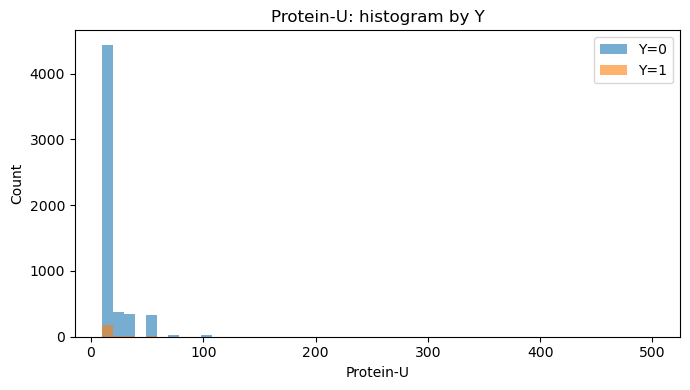

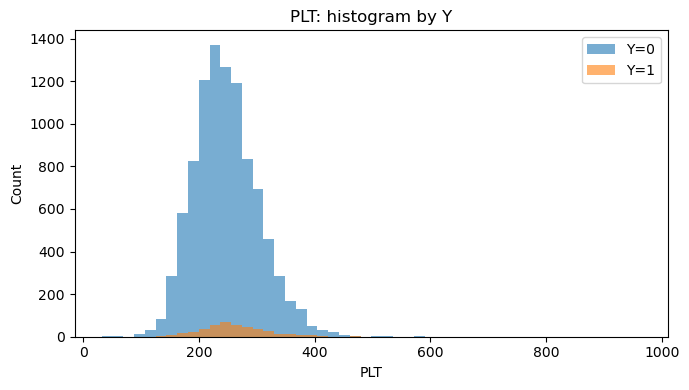

N (PU=0): 0, events: 0,  P(Y=1|PU=0) = nan
N (PU>0): 5757, events: 226,  P(Y=1|PU>0) = 0.0393
Absolute lift = nan   Relative risk ≈ nan
Fisher exact (greater) p = 1
Two-proportion z-test (greater) p = nan
Protein-U ≤ 10.00 (Q2): N=4422.0, P(Y=1)=3.91% • > 10.00: N=1335.0, P(Y=1)=3.97% • Δ=0.06 pp
PLT ≤ 181 (Q10): N=1027.0, P(Y=1)=2.82% • > 181: N=8960.0, P(Y=1)=4.49% • Δ=-1.66 pp


C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\stats\proportion.py:1004: RuntimeWarning: invalid value encountered in divide
  prop = count * 1. / nobs
C:\Users\USER\anaconda3\Lib\site-packages\statsmodels\stats\proportion.py:1020: RuntimeWarning: divide by zero encountered in divide
  nobs_fact = np.sum(1. / nobs)


In [29]:
#%% (7) Question 1, 1.1.2 Top Correlations relationships between key variables

#Protein U and PLT
def overlay_hist(df, col, bins=50, density=False):
    """
    Overlaid histogram by Y for a single numeric column.
    Blue = Y=0, Orange = Y=1.
    """
    if col not in df.columns:
        print(f"Missing column: {col}"); return
    if "Y" not in df.columns:
        print("Missing column: Y"); return
    if not is_numeric_dtype(df[col]):
        print(f"Not numeric: {col}"); return

    # align X and Y, drop NA in X
    x = df[col].dropna()
    y = pd.to_numeric(df.loc[x.index, "Y"], errors="coerce").fillna(0).astype(int).clip(0,1)

    x0 = x[y == 0]
    x1 = x[y == 1]

    # shared bin edges so bars align
    edges = np.histogram_bin_edges(pd.concat([x0, x1]), bins=bins)

    plt.figure(figsize=(7, 4))
    plt.hist(x0, bins=edges, alpha=0.6, label="Y=0", color="tab:blue", density=density)
    plt.hist(x1, bins=edges, alpha=0.6, label="Y=1", color="tab:orange", density=density)
    plt.xlabel(col); plt.ylabel("Density" if density else "Count")
    plt.title(f"{col}: histogram by Y")
    plt.legend()
    plt.tight_layout()
    plt.show()

# examples:
overlay_hist(df_data_dedup, "Protein-U", bins=50)  # zero spike vs non-zero
overlay_hist(df_data_dedup, "PLT", bins=50)        # lower tail enrichment

## statisticaly testing 
epsilon = 0.0  # try 0.0 first; set to 0.01 or 0.1 if needed

pu = df["Protein-U"]
mask = pu.notna()
y = pd.to_numeric(df.loc[mask, "Y"], errors="coerce").fillna(0).astype(int)

zero   = (pu[mask] <= epsilon)
nonzer = (pu[mask] >  epsilon)

n0, n1  = int(zero.sum()),  int(nonzer.sum())
e0, e1  = int(y[zero].sum()), int(y[nonzer].sum())

p0 = e0 / n0 if n0 else np.nan
p1 = e1 / n1 if n1 else np.nan
lift_abs = p1 - p0
rr = (p1 / p0) if p0 and np.isfinite(p0) else np.nan   # relative risk
odds_ratio, p_fisher = fisher_exact([[e1, n1 - e1], [e0, n0 - e0]], alternative="greater")
z, p_z = proportions_ztest([e1, e0], [n1, n0], alternative="larger")

print(f"N (PU=0): {n0}, events: {e0},  P(Y=1|PU=0) = {p0:.4f}")
print(f"N (PU>0): {n1}, events: {e1},  P(Y=1|PU>0) = {p1:.4f}")
print(f"Absolute lift = {lift_abs:.4f}   Relative risk ≈ {rr:.3f}")
print(f"Fisher exact (greater) p = {p_fisher:.3g}")
print(f"Two-proportion z-test (greater) p = {p_z:.3g}")



def best_split(df, col, qs, want_left_higher: bool):
    s = df[col]; m = s.notna()
    y = pd.to_numeric(df.loc[m,"Y"], errors="coerce").fillna(0).astype(int)
    rows = []
    for q in qs:
        cut = s[m].quantile(q)
        lo  = m & (s <= cut)
        hi  = m & (s >  cut)
        p_lo = y[lo].mean() if lo.any() else np.nan
        p_hi = y[hi].mean() if hi.any() else np.nan
        lift = (p_lo - p_hi) if want_left_higher else (p_hi - p_lo)
        rows.append({"q": q, "cut": float(cut), "n_lo": int(lo.sum()), "p_lo": p_lo,
                     "n_hi": int(hi.sum()), "p_hi": p_hi, "lift": lift})
    return pd.DataFrame(rows).sort_values("lift", ascending=False)

# Protein-U: do we want higher rate ABOVE a small cutoff? (right side higher)
pu = best_split(df_data_dedup, "Protein-U", qs=np.arange(0.02, 0.30, 0.02), want_left_higher=False)
r_pu = pu.iloc[0]
print(f"Protein-U ≤ {r_pu.cut:.2f} (Q{int(r_pu.q*100)}): N={r_pu.n_lo}, P(Y=1)={r_pu.p_lo:.2%} • "
      f"> {r_pu.cut:.2f}: N={r_pu.n_hi}, P(Y=1)={r_pu.p_hi:.2%} • Δ={100*(r_pu.p_hi-r_pu.p_lo):.2f} pp")

# PLT: do we want higher rate on the LEFT (low PLT enriched)?
pl = best_split(df_data_dedup, "PLT", qs=np.arange(0.10, 0.40, 0.05), want_left_higher=True)
r_pl = pl.iloc[0]
print(f"PLT ≤ {r_pl.cut:.0f} (Q{int(r_pl.q*100)}): N={r_pl.n_lo}, P(Y=1)={r_pl.p_lo:.2%} • "
      f"> {r_pl.cut:.0f}: N={r_pl.n_hi}, P(Y=1)={r_pl.p_hi:.2%} • Δ={100*(r_pl.p_lo-r_pl.p_hi):.2f} pp")

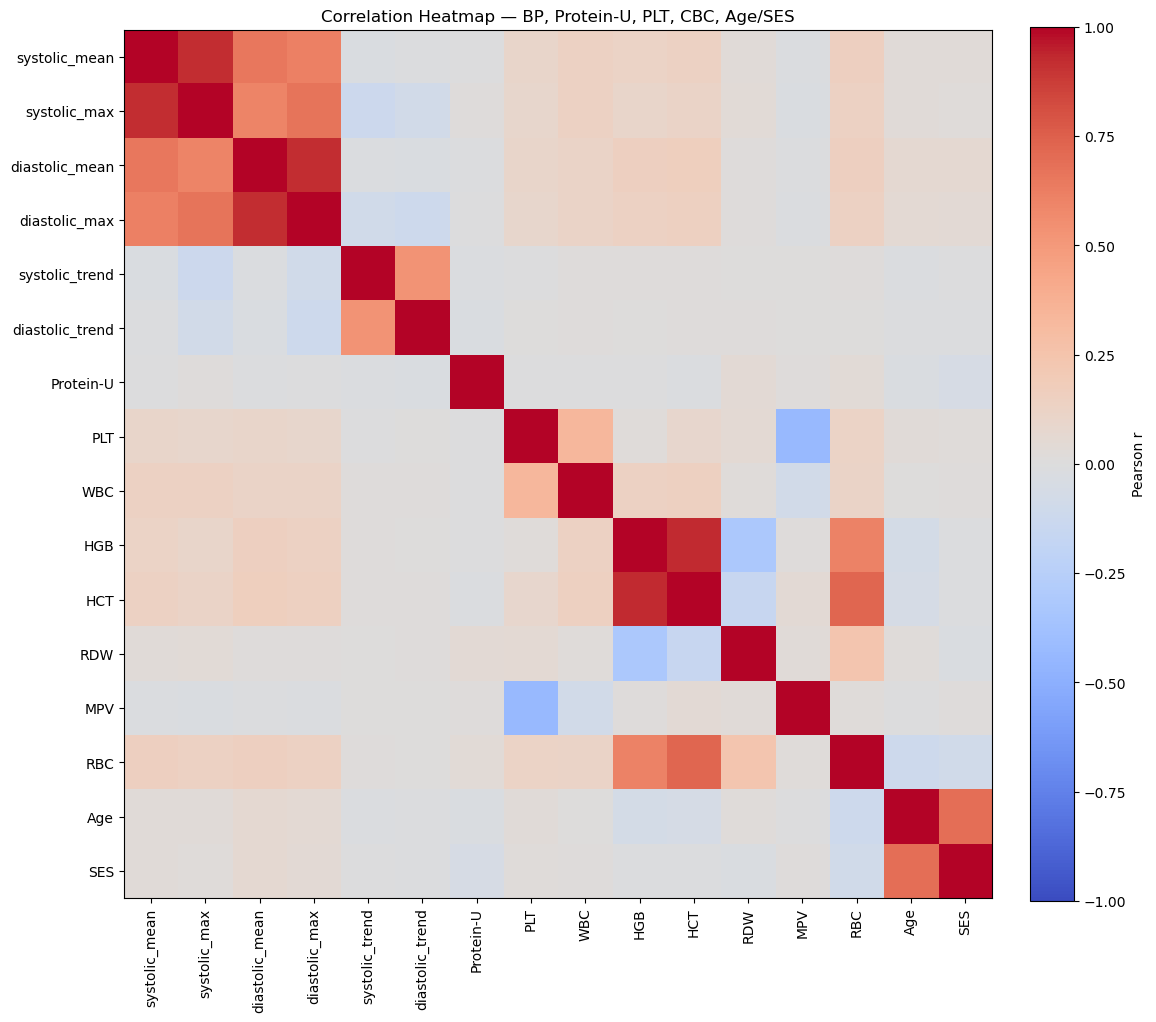

In [30]:
#%%(8)  question 1 Correlation Heatmap — BP, Protein-U, PLT, CBC, Age/SES

cands = ["systolic_mean","systolic_max","diastolic_mean","diastolic_max",
         "systolic_trend","diastolic_trend","Protein-U","PLT",
         "WBC","HGB","HCT","RDW","MPV","RBC","Age","SES"]
feats = [c for c in cands if c in df_data_dedup.columns]
corr = df_data_dedup[feats].corr(min_periods=2)

fig, ax = plt.subplots(figsize=(0.6*len(feats)+2, 0.6*len(feats)+1))
im = ax.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm")
ax.set_xticks(range(len(feats))); ax.set_xticklabels(feats, rotation=90)
ax.set_yticks(range(len(feats))); ax.set_yticklabels(feats)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Pearson r")
ax.set_title("Correlation Heatmap — BP, Protein-U, PLT, CBC, Age/SES")
plt.tight_layout(); plt.show()


In [31]:
#%% (9) Question 3 Pipeline and Success at Fixed Budget - Top-K
#3.	Screening-Prioritization Modeling

drop_like = {"Y","labs_sum","pregnancy_hypertension_sum","preeclampsia_sum","eclampsia_sum","Source breakdown","clinical_text"}
num_cols = df_data_dedup.select_dtypes(include=[np.number]).columns
num_cols = [c for c in num_cols if c not in drop_like and not c.startswith("match_")]
X = df_data_dedup[num_cols].copy()
y = pd.to_numeric(df_data_dedup["Y"], errors="coerce").fillna(0).astype(int)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(with_mean=True, with_std=True),
    LogisticRegression(max_iter=1000, class_weight="balanced")
)
pipe.fit(X_tr, y_tr)

proba = pipe.predict_proba(X_te)[:, 1]
print("Ready: proba shape =", proba.shape)

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['4_diag_88_days_since_last_diag' '4_diag_90_days_since_last_diag']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Ready: proba shape = (2000,)


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['4_diag_88_days_since_last_diag' '4_diag_90_days_since_last_diag']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['4_diag_88_days_since_last_diag' '4_diag_90_days_since_last_diag']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


   budget    K  tp   fp  fn    recall  precision
0    0.05  100  23   77  63  0.267442   0.230000
1    0.10  200  30  170  56  0.348837   0.150000
2    0.15  300  34  266  52  0.395349   0.113333
3    0.20  400  40  360  46  0.465116   0.100000
4    0.25  500  43  457  43  0.500000   0.086000


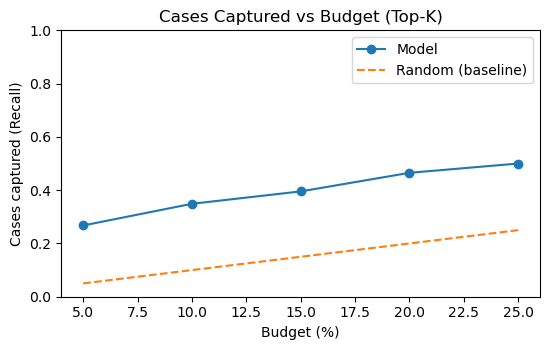

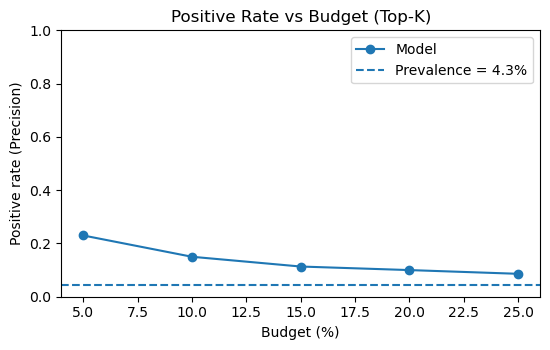

In [32]:
#%% (10) question 3 Model Priorezation and evaluation 
#4.	Budget-Constrained Evaluation

# 1- Scores on holdout

proba = pipe.predict_proba(X_te)[:, 1]
y_true = y_te.values

# 2- Evaluate across budgets
budgets = [0.05, 0.10, 0.15, 0.20, 0.25]

def eval_at_budget(y, s, frac):
    n = len(y); K = max(1, int(round(frac*n)))
    order = np.argsort(s)[::-1]
    sel = order[:K]
    tp = int((y[sel] == 1).sum())
    fp = K - tp
    fn = int((y == 1).sum()) - tp
    recall = tp / max(1, int((y == 1).sum()))
    precision = tp / K
    return {"budget": frac, "K": K, "tp": tp, "fp": fp, "fn": fn,
            "recall": recall, "precision": precision}

rows = [eval_at_budget(y_true, proba, b) for b in budgets]
summ = pd.DataFrame(rows)
prevalence = (y_true == 1).mean()

print(summ)

# 3- Plots
x = [int(100*b) for b in summ["budget"]]

plt.figure(figsize=(5.6,3.6))
plt.plot(x, summ["recall"], marker="o", label="Model")
plt.plot(x, np.array(x)/100.0, linestyle="--", label="Random (baseline)")  # recall ~= budget
plt.ylim(0, 1); plt.xlabel("Budget (%)"); plt.ylabel("Cases captured (Recall)")
plt.title("Cases Captured vs Budget (Top-K)"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(5.6,3.6))
plt.plot(x, summ["precision"], marker="o", label="Model")
plt.axhline(prevalence, linestyle="--", label=f"Prevalence = {prevalence:.1%}")
plt.ylim(0, 1); plt.xlabel("Budget (%)"); plt.ylabel("Positive rate (Precision)")
plt.title("Positive Rate vs Budget (Top-K)"); plt.legend(); plt.tight_layout(); plt.show()

In [33]:
#%% (11) question 3 Modeling Data Setup & Budgeted Evaluation Helper

budgets = [0.05, 0.10, 0.15, 0.20, 0.25]

def eval_at_budget(y_true, scores, frac):
    n = len(y_true); K = max(1, int(round(frac*n)))
    order = np.argsort(scores)[::-1]
    sel = order[:K]
    tp = int((y_true[sel] == 1).sum())
    fp = K - tp
    fn = int((y_true == 1).sum()) - tp
    recall = tp / max(1, int((y_true == 1).sum()))
    precision = tp / K
    return {"budget": frac, "K": K, "tp": tp, "fp": fp, "fn": fn,
            "recall": recall, "precision": precision}

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['4_diag_88_days_since_last_diag' '4_diag_90_days_since_last_diag']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['4_diag_88_days_since_last_diag' '4_diag_90_days_since_last_diag']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Random Forest summary by budget:
    budget    K  tp   fp  fn    recall  precision
0    0.05  100  25   75  61  0.290698   0.250000
1    0.10  200  36  164  50  0.418605   0.180000
2    0.15  300  41  259  45  0.476744   0.136667
3    0.20  400  44  356  42  0.511628   0.110000
4    0.25  500  48  452  38  0.558140   0.096000


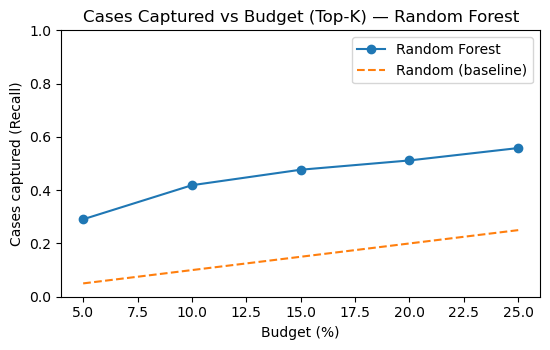

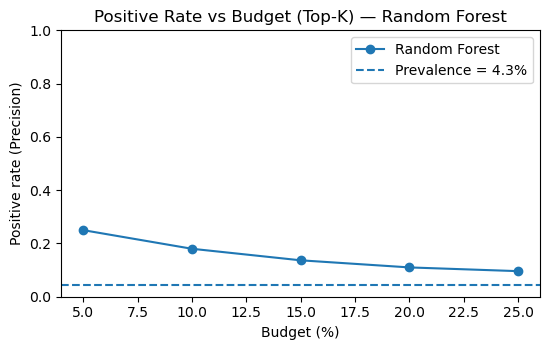

In [34]:
#%% (12) question 3 Random Forest - Alternative Model 1
#3.	Screening-Prioritization Modeling

rf_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    RandomForestClassifier(
        n_estimators=400,
        min_samples_leaf=2,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )
)
rf_pipe.fit(X_tr, y_tr)
rf_proba = rf_pipe.predict_proba(X_te)[:, 1]
y_true   = y_te.values

rf_rows = [eval_at_budget(y_true, rf_proba, b) for b in budgets]
rf_summ  = pd.DataFrame(rf_rows)
prevalence = (y_true == 1).mean()
print("Random Forest summary by budget:\n", rf_summ)

# Plots
x = [int(100*b) for b in rf_summ["budget"]]

plt.figure(figsize=(5.6,3.6))
plt.plot(x, rf_summ["recall"], marker="o", label="Random Forest")
plt.plot(x, np.array(x)/100.0, linestyle="--", label="Random (baseline)")
plt.ylim(0, 1); plt.xlabel("Budget (%)"); plt.ylabel("Cases captured (Recall)")
plt.title("Cases Captured vs Budget (Top-K) — Random Forest"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(5.6,3.6))
plt.plot(x, rf_summ["precision"], marker="o", label="Random Forest")
plt.axhline(prevalence, linestyle="--", label=f"Prevalence = {prevalence:.1%}")
plt.ylim(0, 1); plt.xlabel("Budget (%)"); plt.ylabel("Positive rate (Precision)")
plt.title("Positive Rate vs Budget (Top-K) — Random Forest"); plt.legend(); plt.tight_layout(); plt.show()

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['4_diag_88_days_since_last_diag' '4_diag_90_days_since_last_diag']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Gradient Boosting summary by budget:
    budget    K  tp   fp  fn    recall  precision
0    0.05  100  24   76  62  0.279070      0.240
1    0.10  200  32  168  54  0.372093      0.160
2    0.15  300  39  261  47  0.453488      0.130
3    0.20  400  44  356  42  0.511628      0.110
4    0.25  500  48  452  38  0.558140      0.096


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['4_diag_88_days_since_last_diag' '4_diag_90_days_since_last_diag']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


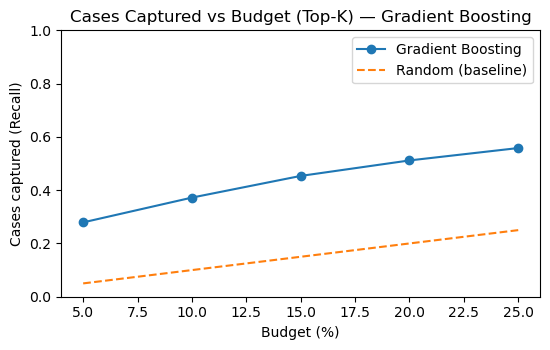

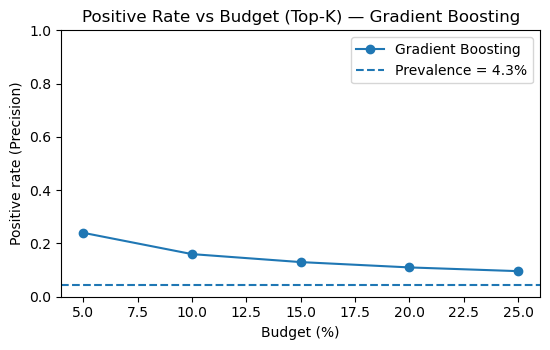

In [35]:
#%% (13) question 3 Gradient Boosting Alternative Model 2

gb_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=400,
        max_depth=3,
        random_state=42
    )
)
gb_pipe.fit(X_tr, y_tr)
gb_proba = gb_pipe.predict_proba(X_te)[:, 1]

gb_rows = [eval_at_budget(y_true, gb_proba, b) for b in budgets]
gb_summ  = pd.DataFrame(gb_rows)
print("Gradient Boosting summary by budget:\n", gb_summ)

# Plots
x = [int(100*b) for b in gb_summ["budget"]]

plt.figure(figsize=(5.6,3.6))
plt.plot(x, gb_summ["recall"], marker="o", label="Gradient Boosting")
plt.plot(x, np.array(x)/100.0, linestyle="--", label="Random (baseline)")
plt.ylim(0, 1); plt.xlabel("Budget (%)"); plt.ylabel("Cases captured (Recall)")
plt.title("Cases Captured vs Budget (Top-K) — Gradient Boosting"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(5.6,3.6))
plt.plot(x, gb_summ["precision"], marker="o", label="Gradient Boosting")
plt.axhline(prevalence, linestyle="--", label=f"Prevalence = {prevalence:.1%}")
plt.ylim(0, 1); plt.xlabel("Budget (%)"); plt.ylabel("Positive rate (Precision)")
plt.title("Positive Rate vs Budget (Top-K) — Gradient Boosting"); plt.legend(); plt.tight_layout(); plt.show()

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['4_diag_88_days_since_last_diag' '4_diag_90_days_since_last_diag']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['4_diag_88_days_since_last_diag' '4_diag_90_days_since_last_diag']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


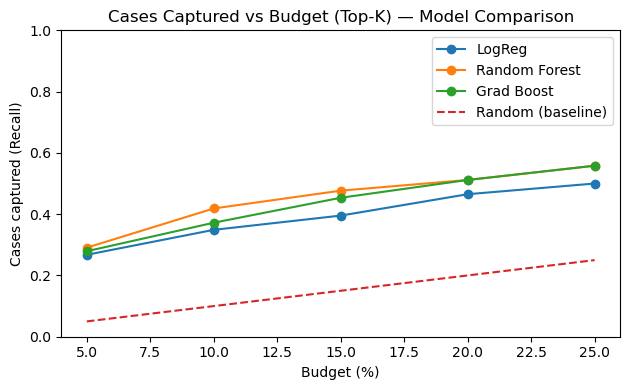

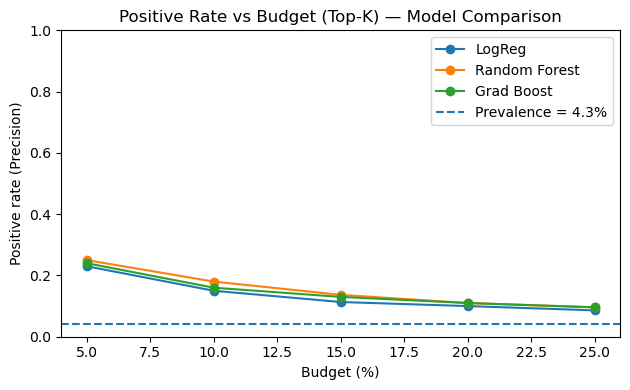

In [15]:
#%% (14) question 3 Overlay comparison across models (same budgets)


##4.Budget-Constrained Evaluation
lr_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    LogisticRegression(max_iter=1000, class_weight="balanced")
)
lr_pipe.fit(X_tr, y_tr)
lr_proba = lr_pipe.predict_proba(X_te)[:, 1]

def budget_curve(y_true, scores, budgets):
    return pd.DataFrame([eval_at_budget(y_true, scores, b) for b in budgets])

lr_summ = budget_curve(y_true, lr_proba, budgets)
rf_summ = budget_curve(y_true, rf_proba, budgets)
gb_summ = budget_curve(y_true, gb_proba, budgets)

x = [int(100*b) for b in budgets]

# Recall overlay
plt.figure(figsize=(6.4,4))
plt.plot(x, lr_summ["recall"], marker="o", label="LogReg")
plt.plot(x, rf_summ["recall"], marker="o", label="Random Forest")
plt.plot(x, gb_summ["recall"], marker="o", label="Grad Boost")
plt.plot(x, np.array(x)/100.0, linestyle="--", label="Random (baseline)")
plt.ylim(0,1); plt.xlabel("Budget (%)"); plt.ylabel("Cases captured (Recall)")
plt.title("Cases Captured vs Budget (Top-K) — Model Comparison")
plt.legend(); plt.tight_layout(); plt.show()

# Precision overlay
plt.figure(figsize=(6.4,4))
plt.plot(x, lr_summ["precision"], marker="o", label="LogReg")
plt.plot(x, rf_summ["precision"], marker="o", label="Random Forest")
plt.plot(x, gb_summ["precision"], marker="o", label="Grad Boost")
plt.axhline(prevalence, linestyle="--", label=f"Prevalence = {prevalence:.1%}")
plt.ylim(0,1); plt.xlabel("Budget (%)"); plt.ylabel("Positive rate (Precision)")
plt.title("Positive Rate vs Budget (Top-K) — Model Comparison")
plt.legend(); plt.tight_layout(); plt.show()

In [36]:
#%% (15) question 4 Decision table at the chosen budget (e.g., B = 20%)
##4.Budget-Constrained Evaluation

B = 0.20  # pick the operational budget
def at_B(name, y_true, scores, B):
    m = eval_at_budget(y_true, scores, B)
    p = (y_true==1).mean()
    return {
        "Model": name,
        "Budget %": int(B*100),
        "K": m["K"],
        "TP": m["tp"], "FP": m["fp"], "FN": m["fn"],
        "Cases captured (Recall)": m["recall"],
        "Positive rate (Precision)": m["precision"],
        "Lift vs random (Recall/B)": m["recall"]/B if B>0 else np.nan,
        "Enrichment vs prevalence (Prec/p)": m["precision"]/p if p>0 else np.nan,
        "NNT (tests per true case)": (m["K"]/m["tp"]) if m["tp"]>0 else np.inf
    }

comp = pd.DataFrame([
    at_B("LogReg",        y_true, lr_proba, B),
    at_B("Random Forest", y_true, rf_proba, B),
    at_B("Grad Boost",    y_true, gb_proba, B),
])
# Format for slide
fmt_cols = ["Cases captured (Recall)", "Positive rate (Precision)",
            "Lift vs random (Recall/B)", "Enrichment vs prevalence (Prec/p)"]
comp[fmt_cols] = comp[fmt_cols].applymap(lambda v: f"{v:.2%}" if isinstance(v,(int,float)) else v)
comp["NNT (tests per true case)"] = comp["NNT (tests per true case)"].apply(lambda v: f"{v:.1f}" if np.isfinite(v) else "∞")
display(comp)

C:\Users\USER\AppData\Local\Temp\ipykernel_11336\3950194494.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  comp[fmt_cols] = comp[fmt_cols].applymap(lambda v: f"{v:.2%}" if isinstance(v,(int,float)) else v)


,Model,Budget %,K,TP,FP,FN,Cases captured (Recall),Positive rate (Precision),Lift vs random (Recall/B),Enrichment vs prevalence (Prec/p),NNT (tests per true case)
0,LogReg,20,400,40,360,46,46.51%,10.00%,232.56%,232.56%,10.0
1,Random Forest,20,400,44,356,42,51.16%,11.00%,255.81%,255.81%,9.1
2,Grad Boost,20,400,44,356,42,51.16%,11.00%,255.81%,255.81%,9.1


        Model  K (tests) Recall Precision Lift vs Random  NNT
       LogReg        400 46.51%    10.00%          2.33× 10.0
Random Forest        400 51.16%    11.00%          2.56×  9.1
   Grad Boost        400 51.16%    11.00%          2.56×  9.1


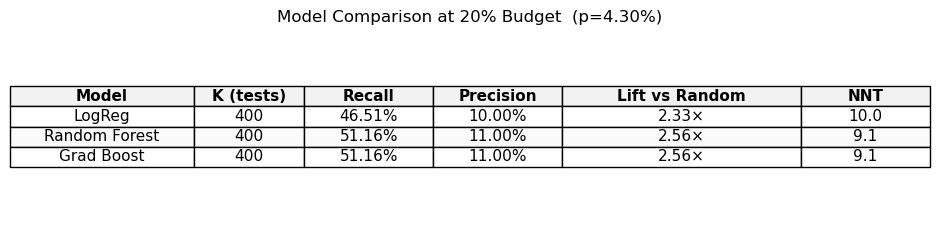

In [17]:
#%% (16) question 5 Build the one-row-per-model table at B 

B = 0.20  # choose operating point
p = (y_te.values == 1).mean()

def at_B_row(name, scores, B=B):
    m = eval_at_budget(y_te.values, scores, B)
    return {
        "Model": name,
        "K (tests)": m["K"],
        "Recall": f"{m['recall']:.2%}",
        "Precision": f"{m['precision']:.2%}",
        "Lift vs Random": f"{(m['recall']/B):.2f}×",
        "NNT": f"{(m['K']/m['tp']):.1f}" if m["tp"]>0 else "∞",
    }

summary_at_B = pd.DataFrame([
    at_B_row("LogReg", lr_proba),
    at_B_row("Random Forest", rf_proba),
    at_B_row("Grad Boost", gb_proba),
])
print(summary_at_B.to_string(index=False))

## VISUALZATION


def quick_table(df, title=None, col_widths=None):
    fig, ax = plt.subplots(figsize=(9.5, 1.2 + 0.4*len(df)))  # wider figure
    ax.axis("off")
    if col_widths is None:
        col_widths = [1/df.shape[1]] * df.shape[1]
    t = ax.table(cellText=df.values, colLabels=df.columns,
                 loc="center", cellLoc="center", colLoc="center",
                 colWidths=col_widths)
    t.auto_set_font_size(False); t.set_fontsize(11); t.scale(1, 1.2)
    for (r, c), cell in t.get_celld().items():
        if r == 0:
            cell.set_text_props(weight="bold"); cell.set_facecolor("#f2f2f2")
        elif r % 2 == 0:
            cell.set_facecolor("#fafafa")
    if title: ax.set_title(title, pad=8)
    plt.tight_layout(); plt.show()

# give extra width to the “Lift vs Random” column (index 4)
widths = [0.20, 0.12, 0.14, 0.14, 0.26, 0.14]
quick_table(summary_at_B, title=f"Model Comparison at {int(B*100)}% Budget  (p={p:.2%})",
            col_widths=widths)

In [37]:
#%% Question 5 choose the final model ONCE and reuse it everywhere
scores = rf_proba         # if Random Forest is my chosen model
y_true = y_te.values.astype(int)

# sanity check: compare 20% across models to see which one is ~51%
for name, s in [("LR", lr_proba), ("RF", rf_proba), ("GB", gb_proba)]:
    n = len(s); K = int(round(0.20*n))
    ord = np.argsort(s)[::-1]; sel = ord[:K]
    recall = (y_true[sel] == 1).sum() / (y_true == 1).sum()
    print(name, "Recall@20% =", f"{recall:.2%}")


LR Recall@20% = 46.51%
RF Recall@20% = 51.16%
GB Recall@20% = 51.16%


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['4_diag_90_days_since_last_diag']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['4_diag_90_days_since_last_diag']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['4_diag_90_days_since_last_diag']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


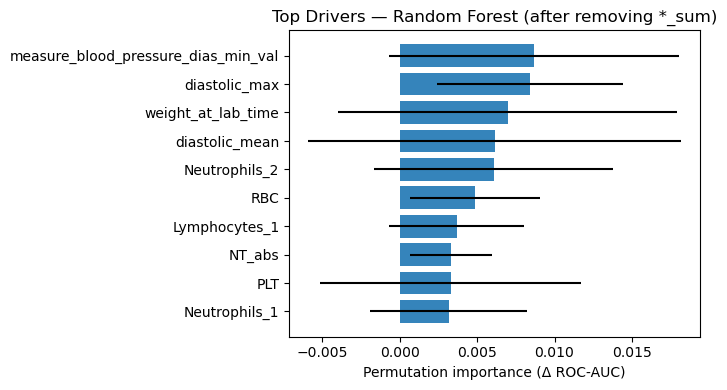

In [19]:
#%% (17) question 5 Validation at 20% Budget for the chosen model (Random Forest) 

y_imp = pd.to_numeric(df["Y"], errors="coerce").fillna(0).astype(int)

drop_exact = {
    "Y", "clinical_text", "Source breakdown",
    "labs_sum", "pregnancy_hypertension_sum", "preeclampsia_sum", "eclampsia_sum",
}

def is_leaky(name: str) -> bool:
    return (
        name.startswith("match_") or
        name.endswith("_sum") or
        "after" in name
    )

num_cols_imp = df.select_dtypes(include="number").columns
keep_imp = [c for c in num_cols_imp if c not in drop_exact and not is_leaky(c)]
X_imp = df[keep_imp].loc[:, df[keep_imp].notna().any(axis=0)].copy()

X_imp_tr, X_imp_te, y_imp_tr, y_imp_te = train_test_split(
    X_imp, y_imp, test_size=0.20, random_state=42, stratify=y_imp
)

rf_imp_pipe = make_pipeline(
    SimpleImputer(strategy="median"),
    RandomForestClassifier(
        n_estimators=400,
        min_samples_leaf=2,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    ),
)
rf_imp_pipe.fit(X_imp_tr, y_imp_tr)

rf_imp_proba = rf_imp_pipe.predict_proba(X_imp_te)[:, 1]

pi = permutation_importance(
    rf_imp_pipe, X_imp_te, y_imp_te.values,
    n_repeats=5,
    random_state=42,
    scoring="roc_auc",
    n_jobs=-1
)

imp = (pd.DataFrame({
        "feature": X_imp_te.columns,
        "imp_mean": pi.importances_mean,
        "imp_std":  pi.importances_std
      })
      .sort_values("imp_mean", ascending=False)
      .head(10))

dirs = []
scores_imp = rf_imp_proba
for f in imp["feature"]:
    x = pd.to_numeric(X_imp_te[f], errors="coerce")
    m = x.notna()
    r = spearmanr(x[m], scores_imp[m]).correlation
    dirs.append("higher → higher risk" if (r >= 0) else "higher → lower risk")
imp["direction"] = dirs

plt.figure(figsize=(7.2, 4.0))
ypos = np.arange(len(imp))[::-1]
plt.barh(ypos, imp["imp_mean"], xerr=1.96*imp["imp_std"], alpha=0.9)
plt.yticks(ypos, imp["feature"])
plt.xlabel("Permutation importance (Δ ROC-AUC)")
plt.title("Top Drivers — Random Forest (after removing *_sum)")
plt.tight_layout(); plt.show()

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['4_diag_90_days_since_last_diag']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\USER\AppData\Local\Temp\ipykernel_11336\190084881.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  base = float(pipe.predict_proba(x0)[:,1])
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['4_diag_90_days_since_last_diag']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\USER\AppData\Local\Temp\ipykernel_11336\190084881.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is depr

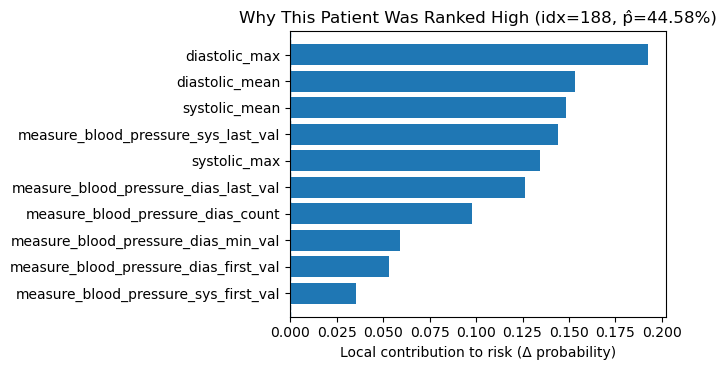

In [38]:
#%% (18) question 5 Validation — Local Explanation (no *_sum)
#  CLEAN model from section 17: rf_imp_pipe / X_imp_te / rf_imp_proba

# pick a patient (highest-risk on holdout for the clean model)
idx_top_imp = int(np.argsort(rf_imp_proba)[-1])

def local_lofo_contribs(pipe, X_ref, row_idx):
    x0 = X_ref.iloc[[row_idx]].copy()
    base = float(pipe.predict_proba(x0)[:,1])
    med  = X_ref.median()
    contrib = {}
    for f in X_ref.columns:
        x1 = x0.copy()
        x1[f] = med[f]
        p1 = float(pipe.predict_proba(x1)[:,1])
        contrib[f] = base - p1  # >0 means this feature pushes risk UP for this patient
    s = pd.Series(contrib).sort_values(key=np.abs, ascending=False)
    return base, s

base_risk_imp, contribs_imp = local_lofo_contribs(rf_imp_pipe, X_imp_te, idx_top_imp)
top10_imp = contribs_imp.head(10).sort_values()  # waterfall-style barh

plt.figure(figsize=(7.0, 3.8))
plt.barh(top10_imp.index, top10_imp.values)
plt.axvline(0, linestyle="--", linewidth=1)
plt.xlabel("Local contribution to risk (Δ probability)")
plt.title(f"Why This Patient Was Ranked High (idx={idx_top_imp}, p̂={base_risk_imp:.2%})")
plt.tight_layout(); plt.show()

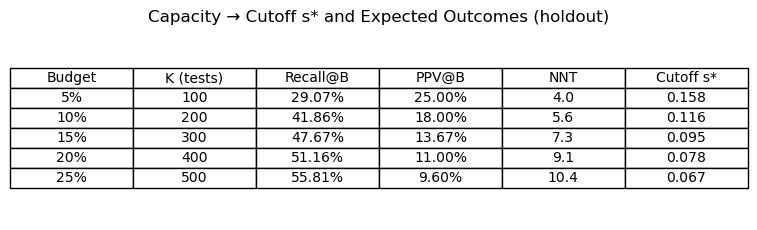

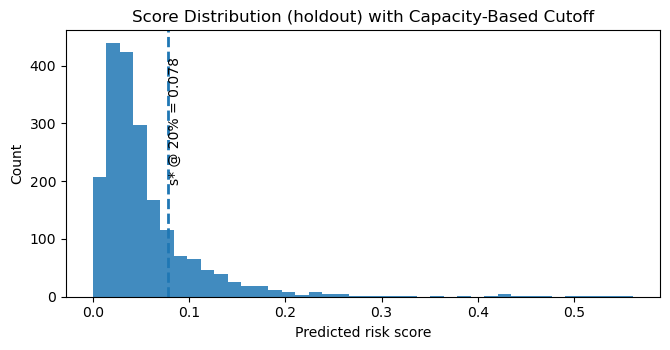

In [21]:
#%% (19) question 5 Validation Setting a Practical Referral Cutoff from Capacity  
def eval_at_budget(y_true, scores, frac):
    n = len(y_true); K = max(1, int(round(frac*n)))
    order = np.argsort(scores)[::-1]
    sel = order[:K]
    tp = int((y_true[sel]==1).sum()); fp = K - tp
    fn = int((y_true==1).sum()) - tp
    recall = tp / max(1, int((y_true==1).sum()))
    precision = tp / K
    nnt = (K / tp) if tp > 0 else np.inf
    return K, recall, precision, nnt

budgets = [0.05, 0.10, 0.15, 0.20, 0.25]
scores = rf_proba
rows = []
order_full = np.argsort(rf_proba)[::-1]
n_full = len(rf_proba)
for B in budgets:
    K, rec, prec, nnt = eval_at_budget(y_te.values, rf_proba, B)
    s_star = float(rf_proba[order_full[K-1]])
    rows.append([f"{int(B*100)}%", K, f"{rec:.2%}", f"{prec:.2%}", f"{nnt:.1f}", f"{s_star:.3f}"])
mini = pd.DataFrame(rows, columns=["Budget", "K (tests)", "Recall@B", "PPV@B", "NNT", "Cutoff s*"])

fig, ax = plt.subplots(figsize=(7.6, 2.4))
ax.axis("off")
tbl = ax.table(cellText=mini.values, colLabels=mini.columns, loc="center", cellLoc="center")
tbl.auto_set_font_size(False); tbl.set_fontsize(10); tbl.scale(1.15, 1.2)
ax.set_title("Capacity → Cutoff s* and Expected Outcomes (holdout)", pad=10)
plt.tight_layout(); plt.show()

B = 0.20
K = int(round(B*len(rf_proba))); order = np.argsort(rf_proba)[::-1]; s_star = float(rf_proba[order[K-1]])
plt.figure(figsize=(6.8, 3.6))
plt.hist(rf_proba, bins=40, alpha=0.85)
plt.axvline(s_star, linestyle="--", linewidth=2)
plt.text(s_star, plt.ylim()[1]*0.9, f"s* @ {int(B*100)}% = {s_star:.3f}", rotation=90, va="top")
plt.xlabel("Predicted risk score"); plt.ylabel("Count")
plt.title("Score Distribution (holdout) with Capacity-Based Cutoff")
plt.tight_layout(); plt.show()